In [3]:
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/Users/soheepark/anaconda3/envs/pydeseq2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [4]:
meta16 = pd.read_csv('GSE167186_metadata_matrix.csv', sep='\t', index_col=[0])
counts16 = pd.read_csv('GSE167186_counts_matrix.csv', sep='\t', index_col=[0], low_memory=False)

meta11 = pd.read_csv('./GSE111006_metadata_matrix.csv', sep='\t', index_col=[0])
counts11 = pd.read_csv('./GSE111006_counts_matrix.csv', sep='\t', index_col=[0], low_memory=False)

In [12]:
print(f'GSE167186: {counts16.shape}')
counts16.head()

GSE167186: (72, 22126)


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,KMT5AP1,BCLAF1P2,LINC01126,CCDC28A.AS1,RPL23AP61,GATD3B,PCDH20,UCKL1.AS1,FRG1KP,ERICD
Sample,,,,,,,,,,,,,,,,,,,,,
OS_10,6,0,20,18,1,3,34,8,11,3,...,1,2,0,0,0,0,0,4,0,0
OH_11,8,1,35,10,2,1,30,2,17,2,...,0,0,0,0,0,0,0,2,0,0
OS_13,10,0,14,6,1,1,35,2,15,3,...,0,0,0,0,0,0,0,0,0,0
OH_14,6,0,22,18,1,0,11,4,18,5,...,1,0,0,0,0,0,0,2,0,0
OH_15,4,1,17,9,2,0,27,7,15,4,...,0,2,0,1,0,0,0,2,0,0


In [14]:
print(f'GSE111006: {counts11.shape}')
counts11.head()

GSE111006: (40, 36683)


,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00550,LINC01394,HCP5B,LINC00602,MIR1291,LINC00891,PAUPAR,ASMER1,HERC2P7,LINC01144
Sample 1,124,7,536,402,141,52,820,150,796,512,...,0,1,11,1,1,1,0,14,0,10
Sample 2,145,6,839,538,119,87,1022,192,844,479,...,0,0,13,1,0,3,0,12,0,13
Sample 3,61,10,415,244,73,25,579,119,397,282,...,0,0,1,0,0,5,0,5,0,15
Sample 4,110,16,690,486,169,76,1027,243,658,582,...,0,1,10,0,0,5,1,31,0,14
Sample 5,122,124,825,538,96,27,1165,231,857,469,...,1,3,9,0,1,4,0,17,2,14


# PCA

In [7]:
dds16 = DeseqDataSet(counts=counts16,
                     metadata=meta16,
                     design_factors="Condition")
dds16

AnnData object with n_obs × n_vars = 72 × 22126
    obs: 'Condition'
    obsm: 'design_matrix'

In [8]:
dds11 = DeseqDataSet(counts=counts11,
                     metadata=meta11,
                     design_factors="Condition")
dds11

AnnData object with n_obs × n_vars = 40 × 36683
    obs: 'Condition'
    obsm: 'design_matrix'

In [9]:
dds = dds16.concatenate(dds11)
dds

AnnData object with n_obs × n_vars = 112 × 20051
    obs: 'Condition', 'batch'
    obsm: 'design_matrix'

In [10]:
dds.obs.Condition.unique()

array(['Sarcopenia', 'Old Healthy', 'Young Healthy', 'OH', 'OS'],
      dtype=object)

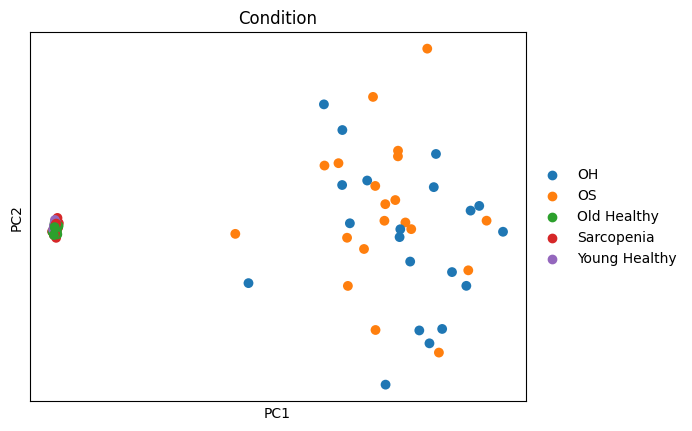

In [11]:
sc.tl.pca(dds)
sc.pl.pca(dds, color='Condition', size=200)

# DEG analysis

## Build merged DeseqDataSet

In [12]:
# 비교를 위해 dds16 라벨 변경
Sample_type = {'Old Healthy':'OH',
               'Sarcopenia':'OS',
               'Young Healthy':'YH',
               'OH':'OH',
               'OS':'OS'
               }
dds16.obs['Condition'] = dds16.obs['Condition'].map(Sample_type)
dds16.obs.head()

,Condition
Sample,
OS_10,OS
OH_11,OH
OS_13,OS
OH_14,OH
OH_15,OH


In [13]:
# Concatenate
dds = dds16.concatenate(dds11)
dds

AnnData object with n_obs × n_vars = 112 × 20051
    obs: 'Condition', 'batch'
    obsm: 'design_matrix'

In [14]:
# Merging
dds = DeseqDataSet(counts=dds.X,
                   metadata=pd.DataFrame(dds.obs.Condition),
                   design_factors="Condition")
dds.deseq2()

Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 7.34 seconds.

Fitting dispersion trend curve...
... done in 0.72 seconds.

Fitting MAP dispersions...
... done in 9.38 seconds.

Fitting LFCs...
... done in 6.25 seconds.

Replacing 106 outlier genes.

Fitting dispersions...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 0.08 seconds.

Fitting LFCs...
... done in 0.07 seconds.



In [15]:
# deseq 계산
dds.deseq2()

Fitting size factors...
... done in 0.11 seconds.

Fitting dispersions...
... done in 7.48 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 9.15 seconds.

Fitting LFCs...
... done in 5.85 seconds.

Replacing 106 outlier genes.

Fitting dispersions...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 0.09 seconds.

Fitting LFCs...
... done in 0.07 seconds.



In [16]:
dds.obs.Condition.unique()

array(['OS', 'OH', 'YH'], dtype=object)

In [121]:
stat_res = DeseqStats(dds, contrast=('Condition',
                                      dds.obs.Condition.unique()[0],
                                      dds.obs.Condition.unique()[1])) 
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Condition OS vs OH
        baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0      16.390778        0.032650  0.090319  0.361496  0.717729  0.999972
1       2.451843       -0.017949  0.401740 -0.044679  0.964363  0.999972
2      73.441410       -0.066540  0.060827 -1.093916  0.273992  0.999972
3      40.137679        0.007231  0.098091  0.073720  0.941233  0.999972
4       3.984815        0.048123  0.246532  0.195201  0.845236  0.999972
...          ...             ...       ...       ...       ...       ...
20046   1.211245        0.160797  0.397136  0.404890  0.685558  0.999972
20047   0.707150       -0.078745  1.053451 -0.074750  0.940414  0.999972
20048   0.063948       -0.246842  1.640392 -0.150477  0.880388  0.999972
20049   0.139826        0.030973  0.502103  0.061686  0.950813  0.999972
20050   0.633480        0.239236  0.303778  0.787536  0.430968  0.999972

[20051 rows x 6 columns]


... done in 1.96 seconds.



In [122]:
# 3. Deseq2Stat
res = stat_res.results_df
res

# 4. Save res as csv
# res.to_csv(f'/Users/soheepark/03-GEO근감소/Results/GSE167186_{name}.csv')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,16.390778,0.032650,0.090319,0.361496,0.717729,0.999972
1,2.451843,-0.017949,0.401740,-0.044679,0.964363,0.999972
2,73.441410,-0.066540,0.060827,-1.093916,0.273992,0.999972
3,40.137679,0.007231,0.098091,0.073720,0.941233,0.999972
4,3.984815,0.048123,0.246532,0.195201,0.845236,0.999972
...,...,...,...,...,...,...
20046,1.211245,0.160797,0.397136,0.404890,0.685558,0.999972
20047,0.707150,-0.078745,1.053451,-0.074750,0.940414,0.999972
20048,0.063948,-0.246842,1.640392,-0.150477,0.880388,0.999972
20049,0.139826,0.030973,0.502103,0.061686,0.950813,0.999972


# Visualization

## Heatmap

In [123]:
lfc_cutoff = 2

sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > lfc_cutoff)]
print(f"Total gene counts: {len(res[res.padj < 0.05])}") 
print(f"Up-regulated: {len(res[(res.padj < 0.05) & (res.log2FoldChange > lfc_cutoff)])}")
print(f"Down-regulated: {len(res[(res.padj < 0.05) & (res.log2FoldChange < -lfc_cutoff)])}")
print(f"Intersected gene counts: {len(res[res.padj < 0.05])-len(res[(res.padj < 0.05) & (abs(res.log2FoldChange) > lfc_cutoff)])}")

print(sigs.shape)
sigs.head()

Total gene counts: 4
Up-regulated: 1
Down-regulated: 0
Intersected gene counts: 3
(1, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7615,6.743926,6.097447,1.127393,5.408447,6.357373e-08,0.001275


In [124]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 112 × 1
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'

In [ ]:
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, 
                       columns=dds_sigs.obs_names)

In [ ]:
sns.clustermap(grapher, 
               z_score=0, 
               cmap = 'RdYlBu_r', 
               xticklabels=True,
               yticklabels=True,
               # row_cluster=None,
               cbar_pos=(1, 0.1, 0.02, 0.3),
              figsize=(10, 6))
               # figsize=(12,3))
plt.show()

## Volcanoplot

In [ ]:
print(grapher.index)
res['Symbol'] = res.index

In [ ]:
volcano(res, symbol='Symbol', to_label = grapher.index)